### 环境准备和依赖导入

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator


import os
import time
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt
import torchvision.models as models
import torchsummary
import time
from torch.optim.lr_scheduler import ExponentialLR


d:\py\Anaconda3\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 使用tensorboard记录训练过程
from torch.utils.tensorboard import SummaryWriter

summaryWriter = SummaryWriter("./logs/")


In [4]:
# 加载数据集
batch_size = 64

**这个方法实现了两种数据缩放策略：**
>- 当 mul='0.5' 时：将输入数据统一缩放为原来的一半
>- 当 mul='random' 时：使用随机数对数据进行缩放（范围在0到1之间）
最后将数据转换为32位浮点数格式返回

**这种预处理的主要目的是：**
>- 数据归一化，使数据范围更适合深度学习模型训练
>- 通过随机缩放增加数据的多样性，可以作为一种数据增强方法
>- 确保数据类型的统一性（float32）

In [5]:
# 数据预处理
class Transform3D:

    def __init__(self, mul=None):
        self.mul = mul

    def __call__(self, voxel):
   
        if self.mul == '0.5':
            voxel = voxel * 0.5
        elif self.mul == 'random':
            voxel = voxel * np.random.uniform()
        
        return voxel.astype(np.float32)

###  数据集加载

In [6]:
print('==> Preparing data...')
# 为验证集和测试集创建固定缩放(0.5)的变换器
train_transform = Transform3D(mul='random') 
eval_transform = Transform3D(mul='0.5')

# 数据集配置
data_flag = 'organmnist3d' # Multi-Class (11)
download = True

# 数据集类获取
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# 数据集加载
train_dataset = DataClass(split='train', transform=train_transform, download=download)
val_dataset = DataClass(split='val', transform=eval_transform, download=download)
test_dataset = DataClass(split='test', transform=eval_transform, download=download)


==> Preparing data...
Using downloaded and verified file: C:\Users\Administrator\.medmnist\organmnist3d.npz
Using downloaded and verified file: C:\Users\Administrator\.medmnist\organmnist3d.npz
Using downloaded and verified file: C:\Users\Administrator\.medmnist\organmnist3d.npz


### 3D数据集可视化

In [7]:
# 3D数据集可视化
def draw_oct(volume, type_volume = 'np',canal_first = False):
    if type_volume == 'np':
        if canal_first == False:
            print("taille du volume = %s (%s)"%(volume.shape,type_volume))
            slice_h_n, slice_d_n , slice_w_n = int(volume.shape[0]/2),int(volume.shape[1]/2),int(volume.shape[2]/2) 
            slice_h = volume[slice_h_n,:,:,:]
            slice_d = volume[:,slice_d_n,:,:]
            slice_w = volume[:,:,slice_w_n,:]
            slice_h = Image.fromarray(np.squeeze(slice_h))
            slice_d = Image.fromarray(np.squeeze(slice_d))
            slice_w = Image.fromarray(np.squeeze(slice_w))
            plt.figure(figsize=(21,7))
            plt.subplot(1, 3, 1)
            plt.imshow(slice_h)
            plt.title(slice_h.size)
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(slice_d)
            plt.title(slice_d.size)
            plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(slice_w)
            plt.title(slice_w.size)
            plt.axis('off')
        if canal_first == True:
            print("taille du volume = %s (%s)"%(volume.shape,type_volume))
            slice_h_n, slice_d_n , slice_w_n = int(volume.shape[1]/2),int(volume.shape[2]/2),int(volume.shape[3]/2) 
            slice_h = volume[:,slice_h_n,:,:]
            slice_d = volume[:,:,slice_d_n,:]
            slice_w = volume[:,:,:,slice_w_n]
            slice_h = Image.fromarray(np.squeeze(slice_h))
            slice_d = Image.fromarray(np.squeeze(slice_d))
            slice_w = Image.fromarray(np.squeeze(slice_w))
            plt.figure(figsize=(21,7))
            plt.subplot(1, 3, 1)
            plt.imshow(slice_h)
            plt.title(slice_h.size)
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(slice_d)
            plt.title(slice_d.size)
            plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(slice_w)
            plt.title(slice_w.size)
            plt.axis('off')
            
    if type_volume == 'tensor':
        if canal_first == False:
            print("taille du volume = %s (%s)"%(volume.shape,type_volume))
            slice_h_n, slice_d_n , slice_w_n = int(volume.shape[0]/2),int(volume.shape[1]/2),int(volume.shape[2]/2) 
            slice_h = volume[slice_h_n,:,:,:].numpy()
            slice_d = volume[:,slice_d_n,:,:].numpy()
            slice_w = volume[:,:,slice_w_n,:].numpy()
            slice_h = Image.fromarray(np.squeeze(slice_h))
            slice_d = Image.fromarray(np.squeeze(slice_d))
            slice_w = Image.fromarray(np.squeeze(slice_w))
            plt.figure(figsize=(21,7))
            plt.subplot(1, 3, 1)
            plt.imshow(slice_h)
            plt.title(slice_h.size)
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(slice_d)
            plt.title(slice_d.size)
            plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(slice_w)
            plt.title(slice_w.size)
            plt.axis('off')
        if canal_first == True:
            slice_h_n, slice_d_n , slice_w_n = int(volume.shape[1]/2),int(volume.shape[2]/2),int(volume.shape[3]/2) 
            slice_h = volume[:,slice_h_n,:,:].numpy()
            slice_d = volume[:,:,slice_d_n,:].numpy()
            slice_w = volume[:,:,:,slice_w_n].numpy()
            slice_h = Image.fromarray(np.squeeze(slice_h))
            slice_d = Image.fromarray(np.squeeze(slice_d))
            slice_w = Image.fromarray(np.squeeze(slice_w))
            plt.figure(figsize=(21,7))
            plt.subplot(1, 3, 1)
            plt.imshow(slice_h)
            plt.title(slice_h.size)
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(slice_d)
            plt.title(slice_d.size)
            plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(slice_w)
            plt.title(slice_w.size)
            plt.axis('off')



(1, 28, 28, 28) [3]
taille du volume = (1, 28, 28, 28) (np)


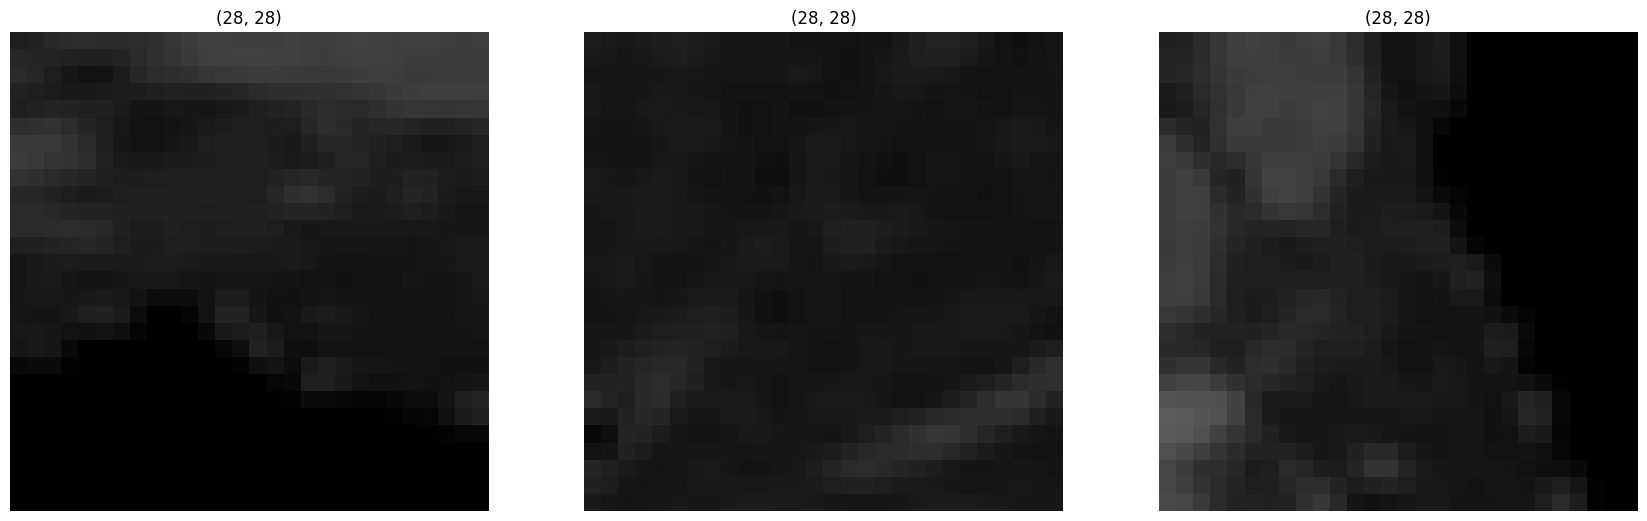

In [8]:
x, y = train_dataset[0]
print(x.shape, y)
draw_oct(x*500,type_volume = 'np',canal_first = True)

In [9]:
train_loader = data.DataLoader(dataset=train_dataset,
                            batch_size=batch_size,
                            shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset,
                            batch_size=batch_size,
                            shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            shuffle=False)

In [10]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break
# torch.Size([256, 1, 28, 28, 28]) torch.Size([256, 1])

torch.Size([64, 1, 28, 28, 28]) torch.Size([64, 1])


In [11]:
from models import resnet

In [12]:
import torch

# 检查 CUDA 是否可用
print(f"CUDA 是否可用: {torch.cuda.is_available()}")

# 如果 CUDA 可用，显示 GPU 信息
if torch.cuda.is_available():
    print(f"GPU 数量: {torch.cuda.device_count()}")
    print(f"GPU 名称: {torch.cuda.get_device_name(0)}")
    print(f"当前 GPU 索引: {torch.cuda.current_device()}")

CUDA 是否可用: True
GPU 数量: 1
GPU 名称: NVIDIA GeForce RTX 3060 Laptop GPU
当前 GPU 索引: 0


In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device =',device)
print(torch.cuda.get_device_name(0))


device = cuda:0
NVIDIA GeForce RTX 3060 Laptop GPU


In [14]:
def generate_model(model_type='resnet',   # 模型类型
                   model_depth=50,        # 模型深度
                   input_W=224,           # 输入宽度
                   input_H=224,           # 输入高度
                   input_D=224,           # 输入深度
                   resnet_shortcut='B',   # ResNet 短路连接类型
                   no_cuda=False,         # 是否不使用 GPU
                   gpu_id=[0],            # GPU 设备ID
                   pretrain_path = 'pretrain/resnet_50.pth',   # 预训练模型路径
                   nb_class=1):           # 输出类别数
    assert model_type in [
        'resnet'
    ]

    if model_type == 'resnet':
        # 验证网络深度是否在有效范围内[10, 18, 34, 50, 101, 152, 200]
        assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    # 每种深度对应不同的特征维度(fc_input)
    if model_depth == 10:
        model = resnet.resnet10(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 256
    elif model_depth == 18:
        model = resnet.resnet18(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 512
    elif model_depth == 34:
        model = resnet.resnet34(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 512
    elif model_depth == 50:
        model = resnet.resnet50(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 2048
    elif model_depth == 101:
        model = resnet.resnet101(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 2048
    elif model_depth == 152:
        model = resnet.resnet152(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 2048
    elif model_depth == 200:
        model = resnet.resnet200(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 2048

    model.conv_seg = nn.Sequential(nn.AdaptiveAvgPool3d((1, 1, 1)),   # 自适应平均池化，将任意大小的3D特征图压缩到指定大小(1x1x1)
                                   nn.Flatten(),                      # 展平，将多维张量"压平"成一维向量
                                   nn.Linear(in_features=fc_input, out_features=nb_class, bias=True)) # 全连接层，执行线性变换，将特征映射到类别空间

    if not no_cuda:
        if len(gpu_id) > 1:
            model = model.cuda()
            model = nn.DataParallel(model, device_ids=gpu_id)
            net_dict = model.state_dict()
        else:
            import os
            os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu_id[0])
            model = model.cuda()
            model = nn.DataParallel(model, device_ids=None)
            net_dict = model.state_dict()
    else:
        net_dict = model.state_dict()

    print('loading pretrained model {}'.format(pretrain_path))
    pretrain = torch.load(pretrain_path)
    pretrain_dict = {k: v for k, v in pretrain['state_dict'].items() if k in net_dict.keys()}
    # k 是每一层的名称，v是权重数值
    net_dict.update(pretrain_dict) #字典 dict2 的键/值对更新到 dict 里。
    model.load_state_dict(net_dict) #model.load_state_dict()函数把加载的权重复制到模型的权重中去

    print("-------- pre-train model load successfully --------")

    return model


In [15]:
model = generate_model(model_type='resnet', 
                       model_depth=50,
                       input_W=224, 
                       input_H=224, 
                       input_D=224, 
                       resnet_shortcut='B',
                       no_cuda=False, 
                       gpu_id=[0],
                       pretrain_path = './MedicalNet_pytorch_files2/pretrain/resnet_50_23dataset.pth',
                       nb_class=11)


c:\Users\Administrator\Desktop\medmnist\models\resnet.py:173: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


loading pretrained model ./MedicalNet_pytorch_files2/pretrain/resnet_50_23dataset.pth
-------- pre-train model load successfully --------


In [16]:
# 使用Adam优化算法，初始学习率为0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# 使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()
# 使用指数衰减学习率调度器
scheduler = ExponentialLR(optimizer, gamma=0.99)
# 训练模型
num_epochs = 800

In [17]:
# 在代码开头添加
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

**性能监控：**
1. 同时跟踪训练和验证的准确率
2. 记录每个epoch的训练时间
3. 使用TensorBoard进行可视化

**优化策略：**
1. 使用学习率调度器(scheduler.step())
2. 每个epoch结束后更新学习率

**内存管理：**
1. 训练时启用梯度计算
2. 验证时禁用梯度计算以节省内存

**进度显示：**
1. 使用tqdm显示训练和验证的进度条
2. 打印每个epoch的训练损失和准确率

In [19]:
# 训练循环初始化
total_step = len(train_loader)
time_list = []
for epoch in range(num_epochs):
    start = time.time()
    per_epoch_loss = 0
    num_correct= 0
    val_num_correct = 0 
    model.train()
    with torch.enable_grad():
        for x,label in tqdm(train_loader):
            
            # 将数据移动到GPU上
            x = x.to(device)
            label = label.to(device).long()
            label = torch.squeeze(label)# label的形状是 [256,1] 要将其变成 [256]
            # 前向传播，计算预测值和损失
            logits = model(x)
            loss = criterion(logits, label)

            per_epoch_loss += loss.item()

            # 反向传播，更新模型参数
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pred = logits.argmax(dim=1)
            num_correct += torch.eq(pred, label).sum().float().item()
        print("Train Epoch: {}\t Loss: {:.6f}\t Acc: {:.6f}".format(epoch,per_epoch_loss/total_step,num_correct/len(train_loader.dataset)))
        # 记录训练损失和准确率
        summaryWriter.add_scalars('loss', {"loss":(per_epoch_loss/total_step)}, epoch)
        summaryWriter.add_scalars('acc', {"acc":num_correct/len(train_loader.dataset)}, epoch)

    # 验证阶段   
    model.eval()
    with torch.no_grad():
        for x,label in tqdm(val_loader):
            # 验证过程
            x = x.to(device)
            label = label.to(device)
            label = torch.squeeze(label)
            # 验证过程，不需要计算梯度
            logits = model(x)
            pred = logits.argmax(dim=1)
            val_num_correct += torch.eq(pred, label).sum().float().item()
        print("val Epoch: {}\t Acc: {:.6f}".format(epoch,num_correct/len(train_loader.dataset)))
        
        # 记录验证损失和准确率
        summaryWriter.add_scalars('acc', {"val_acc":val_num_correct/len(val_loader.dataset)}, epoch)
        summaryWriter.add_scalars('time', {"time":(time.time() - start)}, epoch)
    scheduler.step()



100%|██████████| 16/16 [00:03<00:00,  4.42it/s]


Train Epoch: 0	 Loss: 2.268234	 Acc: 0.156540


100%|██████████| 3/3 [00:00<00:00, 17.48it/s]


val Epoch: 0	 Acc: 0.156540


100%|██████████| 16/16 [00:03<00:00,  5.28it/s]


Train Epoch: 1	 Loss: 2.002304	 Acc: 0.240989


100%|██████████| 3/3 [00:00<00:00, 17.54it/s]


val Epoch: 1	 Acc: 0.240989


100%|██████████| 16/16 [00:03<00:00,  5.22it/s]


Train Epoch: 2	 Loss: 1.804892	 Acc: 0.295572


100%|██████████| 3/3 [00:00<00:00, 15.71it/s]


val Epoch: 2	 Acc: 0.295572


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 3	 Loss: 1.628626	 Acc: 0.365602


100%|██████████| 3/3 [00:00<00:00, 17.08it/s]


val Epoch: 3	 Acc: 0.365602


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 4	 Loss: 1.503884	 Acc: 0.439753


100%|██████████| 3/3 [00:00<00:00, 15.40it/s]


val Epoch: 4	 Acc: 0.439753


100%|██████████| 16/16 [00:03<00:00,  4.99it/s]


Train Epoch: 5	 Loss: 1.467245	 Acc: 0.469619


100%|██████████| 3/3 [00:00<00:00, 15.71it/s]


val Epoch: 5	 Acc: 0.469619


100%|██████████| 16/16 [00:03<00:00,  5.02it/s]


Train Epoch: 6	 Loss: 1.280816	 Acc: 0.526262


100%|██████████| 3/3 [00:00<00:00, 16.32it/s]


val Epoch: 6	 Acc: 0.526262


100%|██████████| 16/16 [00:03<00:00,  5.21it/s]


Train Epoch: 7	 Loss: 1.160610	 Acc: 0.580844


100%|██████████| 3/3 [00:00<00:00, 17.16it/s]


val Epoch: 7	 Acc: 0.580844


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 8	 Loss: 1.159596	 Acc: 0.605561


100%|██████████| 3/3 [00:00<00:00, 17.29it/s]


val Epoch: 8	 Acc: 0.605561


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 9	 Loss: 1.003180	 Acc: 0.630278


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 9	 Acc: 0.630278


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 10	 Loss: 0.988131	 Acc: 0.642636


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 10	 Acc: 0.642636


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 11	 Loss: 0.980910	 Acc: 0.644696


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 11	 Acc: 0.644696


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 12	 Loss: 0.877155	 Acc: 0.672503


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 12	 Acc: 0.672503


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 13	 Loss: 0.799852	 Acc: 0.705458


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 13	 Acc: 0.705458


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 14	 Loss: 0.785397	 Acc: 0.713697


100%|██████████| 3/3 [00:00<00:00, 17.10it/s]


val Epoch: 14	 Acc: 0.713697


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 15	 Loss: 0.751168	 Acc: 0.732235


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


val Epoch: 15	 Acc: 0.732235


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 16	 Loss: 0.728371	 Acc: 0.752832


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 16	 Acc: 0.752832


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 17	 Loss: 0.685214	 Acc: 0.739444


100%|██████████| 3/3 [00:00<00:00, 16.92it/s]


val Epoch: 17	 Acc: 0.739444


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 18	 Loss: 0.682073	 Acc: 0.750772


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 18	 Acc: 0.750772


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 19	 Loss: 0.558166	 Acc: 0.813594


100%|██████████| 3/3 [00:00<00:00, 17.20it/s]


val Epoch: 19	 Acc: 0.813594


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 20	 Loss: 0.664186	 Acc: 0.784758


100%|██████████| 3/3 [00:00<00:00, 17.21it/s]


val Epoch: 20	 Acc: 0.784758


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 21	 Loss: 0.583935	 Acc: 0.782698


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 21	 Acc: 0.782698


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 22	 Loss: 0.567922	 Acc: 0.799176


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 22	 Acc: 0.799176


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 23	 Loss: 0.640399	 Acc: 0.796087


100%|██████████| 3/3 [00:00<00:00, 16.82it/s]


val Epoch: 23	 Acc: 0.796087


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 24	 Loss: 0.572908	 Acc: 0.813594


100%|██████████| 3/3 [00:00<00:00, 17.31it/s]


val Epoch: 24	 Acc: 0.813594


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 25	 Loss: 0.470116	 Acc: 0.825953


100%|██████████| 3/3 [00:00<00:00, 16.69it/s]


val Epoch: 25	 Acc: 0.825953


100%|██████████| 16/16 [00:03<00:00,  5.08it/s]


Train Epoch: 26	 Loss: 0.415496	 Acc: 0.847580


100%|██████████| 3/3 [00:00<00:00, 16.61it/s]


val Epoch: 26	 Acc: 0.847580


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 27	 Loss: 0.377335	 Acc: 0.872297


100%|██████████| 3/3 [00:00<00:00, 16.81it/s]


val Epoch: 27	 Acc: 0.872297


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 28	 Loss: 0.483711	 Acc: 0.844490


100%|██████████| 3/3 [00:00<00:00, 16.52it/s]


val Epoch: 28	 Acc: 0.844490


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 29	 Loss: 0.437675	 Acc: 0.855819


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 29	 Acc: 0.855819


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 30	 Loss: 0.420286	 Acc: 0.869207


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 30	 Acc: 0.869207


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 31	 Loss: 0.442201	 Acc: 0.842430


100%|██████████| 3/3 [00:00<00:00, 17.27it/s]


val Epoch: 31	 Acc: 0.842430


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 32	 Loss: 0.400450	 Acc: 0.878476


100%|██████████| 3/3 [00:00<00:00, 17.03it/s]


val Epoch: 32	 Acc: 0.878476


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 33	 Loss: 0.386953	 Acc: 0.870237


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 33	 Acc: 0.870237


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 34	 Loss: 0.352006	 Acc: 0.880536


100%|██████████| 3/3 [00:00<00:00, 16.63it/s]


val Epoch: 34	 Acc: 0.880536


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 35	 Loss: 0.327272	 Acc: 0.891864


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 35	 Acc: 0.891864


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 36	 Loss: 0.336739	 Acc: 0.888774


100%|██████████| 3/3 [00:00<00:00, 17.21it/s]


val Epoch: 36	 Acc: 0.888774


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 37	 Loss: 0.311612	 Acc: 0.897013


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 37	 Acc: 0.897013


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 38	 Loss: 0.266327	 Acc: 0.906282


100%|██████████| 3/3 [00:00<00:00, 17.34it/s]


val Epoch: 38	 Acc: 0.906282


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 39	 Loss: 0.248156	 Acc: 0.919670


100%|██████████| 3/3 [00:00<00:00, 17.25it/s]


val Epoch: 39	 Acc: 0.919670


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 40	 Loss: 0.282094	 Acc: 0.897013


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 40	 Acc: 0.897013


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 41	 Loss: 0.227871	 Acc: 0.918641


100%|██████████| 3/3 [00:00<00:00, 16.67it/s]


val Epoch: 41	 Acc: 0.918641


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 42	 Loss: 0.222803	 Acc: 0.921730


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 42	 Acc: 0.921730


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 43	 Loss: 0.230536	 Acc: 0.925850


100%|██████████| 3/3 [00:00<00:00, 16.57it/s]


val Epoch: 43	 Acc: 0.925850


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 44	 Loss: 0.274255	 Acc: 0.919670


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 44	 Acc: 0.919670


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 45	 Loss: 0.511285	 Acc: 0.852729


100%|██████████| 3/3 [00:00<00:00, 17.25it/s]


val Epoch: 45	 Acc: 0.852729


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 46	 Loss: 0.401352	 Acc: 0.876416


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 46	 Acc: 0.876416


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 47	 Loss: 0.336581	 Acc: 0.884655


100%|██████████| 3/3 [00:00<00:00, 17.27it/s]


val Epoch: 47	 Acc: 0.884655


100%|██████████| 16/16 [00:03<00:00,  5.21it/s]


Train Epoch: 48	 Loss: 0.311000	 Acc: 0.916581


100%|██████████| 3/3 [00:00<00:00, 17.34it/s]


val Epoch: 48	 Acc: 0.916581


100%|██████████| 16/16 [00:03<00:00,  5.22it/s]


Train Epoch: 49	 Loss: 0.276573	 Acc: 0.902163


100%|██████████| 3/3 [00:00<00:00, 17.41it/s]


val Epoch: 49	 Acc: 0.902163


100%|██████████| 16/16 [00:03<00:00,  5.22it/s]


Train Epoch: 50	 Loss: 0.203254	 Acc: 0.939238


100%|██████████| 3/3 [00:00<00:00, 17.38it/s]


val Epoch: 50	 Acc: 0.939238


100%|██████████| 16/16 [00:03<00:00,  5.22it/s]


Train Epoch: 51	 Loss: 0.185402	 Acc: 0.934089


100%|██████████| 3/3 [00:00<00:00, 17.28it/s]


val Epoch: 51	 Acc: 0.934089


100%|██████████| 16/16 [00:03<00:00,  5.23it/s]


Train Epoch: 52	 Loss: 0.195919	 Acc: 0.944387


100%|██████████| 3/3 [00:00<00:00, 17.40it/s]


val Epoch: 52	 Acc: 0.944387


100%|██████████| 16/16 [00:03<00:00,  5.23it/s]


Train Epoch: 53	 Loss: 0.167128	 Acc: 0.953656


100%|██████████| 3/3 [00:00<00:00, 17.34it/s]


val Epoch: 53	 Acc: 0.953656


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 54	 Loss: 0.190505	 Acc: 0.945417


100%|██████████| 3/3 [00:00<00:00, 16.92it/s]


val Epoch: 54	 Acc: 0.945417


100%|██████████| 16/16 [00:03<00:00,  5.09it/s]


Train Epoch: 55	 Loss: 0.202276	 Acc: 0.930999


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 55	 Acc: 0.930999


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 56	 Loss: 0.157001	 Acc: 0.942327


100%|██████████| 3/3 [00:00<00:00, 15.83it/s]


val Epoch: 56	 Acc: 0.942327


100%|██████████| 16/16 [00:03<00:00,  5.07it/s]


Train Epoch: 57	 Loss: 0.142842	 Acc: 0.959835


100%|██████████| 3/3 [00:00<00:00, 15.99it/s]


val Epoch: 57	 Acc: 0.959835


100%|██████████| 16/16 [00:03<00:00,  5.06it/s]


Train Epoch: 58	 Loss: 0.208211	 Acc: 0.934089


100%|██████████| 3/3 [00:00<00:00, 16.02it/s]


val Epoch: 58	 Acc: 0.934089


100%|██████████| 16/16 [00:03<00:00,  5.08it/s]


Train Epoch: 59	 Loss: 0.142214	 Acc: 0.950566


100%|██████████| 3/3 [00:00<00:00, 15.92it/s]


val Epoch: 59	 Acc: 0.950566


100%|██████████| 16/16 [00:03<00:00,  5.08it/s]


Train Epoch: 60	 Loss: 0.144793	 Acc: 0.951596


100%|██████████| 3/3 [00:00<00:00, 15.99it/s]


val Epoch: 60	 Acc: 0.951596


100%|██████████| 16/16 [00:03<00:00,  5.08it/s]


Train Epoch: 61	 Loss: 0.144433	 Acc: 0.959835


100%|██████████| 3/3 [00:00<00:00, 15.96it/s]


val Epoch: 61	 Acc: 0.959835


100%|██████████| 16/16 [00:03<00:00,  5.08it/s]


Train Epoch: 62	 Loss: 0.150484	 Acc: 0.957775


100%|██████████| 3/3 [00:00<00:00, 15.87it/s]


val Epoch: 62	 Acc: 0.957775


100%|██████████| 16/16 [00:03<00:00,  5.08it/s]


Train Epoch: 63	 Loss: 0.146220	 Acc: 0.956746


100%|██████████| 3/3 [00:00<00:00, 15.96it/s]


val Epoch: 63	 Acc: 0.956746


100%|██████████| 16/16 [00:03<00:00,  5.04it/s]


Train Epoch: 64	 Loss: 0.125232	 Acc: 0.958805


100%|██████████| 3/3 [00:00<00:00, 15.42it/s]


val Epoch: 64	 Acc: 0.958805


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 65	 Loss: 0.118933	 Acc: 0.959835


100%|██████████| 3/3 [00:00<00:00, 16.35it/s]


val Epoch: 65	 Acc: 0.959835


100%|██████████| 16/16 [00:03<00:00,  5.09it/s]


Train Epoch: 66	 Loss: 0.250676	 Acc: 0.954686


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


val Epoch: 66	 Acc: 0.954686


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 67	 Loss: 0.264715	 Acc: 0.915551


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 67	 Acc: 0.915551


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 68	 Loss: 0.165939	 Acc: 0.944387


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 68	 Acc: 0.944387


100%|██████████| 16/16 [00:03<00:00,  5.03it/s]


Train Epoch: 69	 Loss: 0.151521	 Acc: 0.955716


100%|██████████| 3/3 [00:00<00:00, 16.65it/s]


val Epoch: 69	 Acc: 0.955716


100%|██████████| 16/16 [00:03<00:00,  5.07it/s]


Train Epoch: 70	 Loss: 0.112745	 Acc: 0.970134


100%|██████████| 3/3 [00:00<00:00, 15.59it/s]


val Epoch: 70	 Acc: 0.970134


100%|██████████| 16/16 [00:03<00:00,  4.93it/s]


Train Epoch: 71	 Loss: 0.122850	 Acc: 0.966014


100%|██████████| 3/3 [00:00<00:00, 15.31it/s]


val Epoch: 71	 Acc: 0.966014


100%|██████████| 16/16 [00:03<00:00,  4.94it/s]


Train Epoch: 72	 Loss: 0.131091	 Acc: 0.955716


100%|██████████| 3/3 [00:00<00:00, 15.79it/s]


val Epoch: 72	 Acc: 0.955716


100%|██████████| 16/16 [00:03<00:00,  4.99it/s]


Train Epoch: 73	 Loss: 0.134871	 Acc: 0.961895


100%|██████████| 3/3 [00:00<00:00, 15.38it/s]


val Epoch: 73	 Acc: 0.961895


100%|██████████| 16/16 [00:03<00:00,  4.93it/s]


Train Epoch: 74	 Loss: 0.160147	 Acc: 0.952626


100%|██████████| 3/3 [00:00<00:00, 15.32it/s]


val Epoch: 74	 Acc: 0.952626


100%|██████████| 16/16 [00:03<00:00,  4.81it/s]


Train Epoch: 75	 Loss: 0.130598	 Acc: 0.953656


100%|██████████| 3/3 [00:00<00:00, 14.42it/s]


val Epoch: 75	 Acc: 0.953656


100%|██████████| 16/16 [00:03<00:00,  4.77it/s]


Train Epoch: 76	 Loss: 0.113622	 Acc: 0.966014


100%|██████████| 3/3 [00:00<00:00, 15.18it/s]


val Epoch: 76	 Acc: 0.966014


100%|██████████| 16/16 [00:03<00:00,  4.96it/s]


Train Epoch: 77	 Loss: 0.120429	 Acc: 0.956746


100%|██████████| 3/3 [00:00<00:00, 15.63it/s]


val Epoch: 77	 Acc: 0.956746


100%|██████████| 16/16 [00:03<00:00,  5.02it/s]


Train Epoch: 78	 Loss: 0.098499	 Acc: 0.970134


100%|██████████| 3/3 [00:00<00:00, 15.90it/s]


val Epoch: 78	 Acc: 0.970134


100%|██████████| 16/16 [00:03<00:00,  5.05it/s]


Train Epoch: 79	 Loss: 0.122823	 Acc: 0.967044


100%|██████████| 3/3 [00:00<00:00, 15.63it/s]


val Epoch: 79	 Acc: 0.967044


100%|██████████| 16/16 [00:03<00:00,  5.05it/s]


Train Epoch: 80	 Loss: 0.092895	 Acc: 0.971164


100%|██████████| 3/3 [00:00<00:00, 15.96it/s]


val Epoch: 80	 Acc: 0.971164


100%|██████████| 16/16 [00:03<00:00,  5.06it/s]


Train Epoch: 81	 Loss: 0.107962	 Acc: 0.955716


100%|██████████| 3/3 [00:00<00:00, 15.90it/s]


val Epoch: 81	 Acc: 0.955716


100%|██████████| 16/16 [00:03<00:00,  5.05it/s]


Train Epoch: 82	 Loss: 0.106235	 Acc: 0.972194


100%|██████████| 3/3 [00:00<00:00, 15.47it/s]


val Epoch: 82	 Acc: 0.972194


100%|██████████| 16/16 [00:03<00:00,  5.05it/s]


Train Epoch: 83	 Loss: 0.081789	 Acc: 0.969104


100%|██████████| 3/3 [00:00<00:00, 15.79it/s]


val Epoch: 83	 Acc: 0.969104


100%|██████████| 16/16 [00:03<00:00,  4.99it/s]


Train Epoch: 84	 Loss: 0.094346	 Acc: 0.966014


100%|██████████| 3/3 [00:00<00:00, 15.46it/s]


val Epoch: 84	 Acc: 0.966014


100%|██████████| 16/16 [00:03<00:00,  4.99it/s]


Train Epoch: 85	 Loss: 0.057638	 Acc: 0.983522


100%|██████████| 3/3 [00:00<00:00, 14.78it/s]


val Epoch: 85	 Acc: 0.983522


100%|██████████| 16/16 [00:03<00:00,  4.76it/s]


Train Epoch: 86	 Loss: 0.096773	 Acc: 0.973223


100%|██████████| 3/3 [00:00<00:00, 13.61it/s]


val Epoch: 86	 Acc: 0.973223


100%|██████████| 16/16 [00:03<00:00,  4.59it/s]


Train Epoch: 87	 Loss: 0.086331	 Acc: 0.973223


100%|██████████| 3/3 [00:00<00:00, 15.78it/s]


val Epoch: 87	 Acc: 0.973223


100%|██████████| 16/16 [00:03<00:00,  5.01it/s]


Train Epoch: 88	 Loss: 0.114843	 Acc: 0.982492


100%|██████████| 3/3 [00:00<00:00, 16.67it/s]


val Epoch: 88	 Acc: 0.982492


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 89	 Loss: 0.136793	 Acc: 0.966014


100%|██████████| 3/3 [00:00<00:00, 16.82it/s]


val Epoch: 89	 Acc: 0.966014


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 90	 Loss: 0.114602	 Acc: 0.963955


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


val Epoch: 90	 Acc: 0.963955


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 91	 Loss: 0.094330	 Acc: 0.968074


100%|██████████| 3/3 [00:00<00:00, 16.98it/s]


val Epoch: 91	 Acc: 0.968074


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 92	 Loss: 0.081754	 Acc: 0.978373


100%|██████████| 3/3 [00:00<00:00, 16.91it/s]


val Epoch: 92	 Acc: 0.978373


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 93	 Loss: 0.105372	 Acc: 0.960865


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 93	 Acc: 0.960865


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 94	 Loss: 0.066383	 Acc: 0.976313


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 94	 Acc: 0.976313


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 95	 Loss: 0.079473	 Acc: 0.975283


100%|██████████| 3/3 [00:00<00:00, 16.78it/s]


val Epoch: 95	 Acc: 0.975283


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 96	 Loss: 0.064947	 Acc: 0.974253


100%|██████████| 3/3 [00:00<00:00, 17.10it/s]


val Epoch: 96	 Acc: 0.974253


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 97	 Loss: 0.071442	 Acc: 0.978373


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 97	 Acc: 0.978373


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 98	 Loss: 0.079742	 Acc: 0.971164


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 98	 Acc: 0.971164


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 99	 Loss: 0.063281	 Acc: 0.978373


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 99	 Acc: 0.978373


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 100	 Loss: 0.067092	 Acc: 0.976313


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 100	 Acc: 0.976313


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 101	 Loss: 0.081087	 Acc: 0.979403


100%|██████████| 3/3 [00:00<00:00, 16.81it/s]


val Epoch: 101	 Acc: 0.979403


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 102	 Loss: 0.244927	 Acc: 0.953656


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 102	 Acc: 0.953656


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 103	 Loss: 0.137124	 Acc: 0.956746


100%|██████████| 3/3 [00:00<00:00, 16.94it/s]


val Epoch: 103	 Acc: 0.956746


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 104	 Loss: 0.097779	 Acc: 0.969104


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


val Epoch: 104	 Acc: 0.969104


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 105	 Loss: 0.135424	 Acc: 0.958805


100%|██████████| 3/3 [00:00<00:00, 16.67it/s]


val Epoch: 105	 Acc: 0.958805


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 106	 Loss: 0.084442	 Acc: 0.970134


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 106	 Acc: 0.970134


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 107	 Loss: 0.113228	 Acc: 0.970134


100%|██████████| 3/3 [00:00<00:00, 16.75it/s]


val Epoch: 107	 Acc: 0.970134


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 108	 Loss: 0.074601	 Acc: 0.973223


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 108	 Acc: 0.973223


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 109	 Loss: 0.070018	 Acc: 0.976313


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 109	 Acc: 0.976313


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 110	 Loss: 0.059746	 Acc: 0.979403


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 110	 Acc: 0.979403


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 111	 Loss: 0.063327	 Acc: 0.984552


100%|██████████| 3/3 [00:00<00:00, 16.43it/s]


val Epoch: 111	 Acc: 0.984552


100%|██████████| 16/16 [00:03<00:00,  5.05it/s]


Train Epoch: 112	 Loss: 0.167301	 Acc: 0.975283


100%|██████████| 3/3 [00:00<00:00, 16.31it/s]


val Epoch: 112	 Acc: 0.975283


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 113	 Loss: 0.117536	 Acc: 0.959835


100%|██████████| 3/3 [00:00<00:00, 16.51it/s]


val Epoch: 113	 Acc: 0.959835


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 114	 Loss: 0.092451	 Acc: 0.975283


100%|██████████| 3/3 [00:00<00:00, 17.08it/s]


val Epoch: 114	 Acc: 0.975283


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 115	 Loss: 0.112781	 Acc: 0.972194


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


val Epoch: 115	 Acc: 0.972194


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 116	 Loss: 0.102032	 Acc: 0.975283


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 116	 Acc: 0.975283


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 117	 Loss: 0.091115	 Acc: 0.972194


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


val Epoch: 117	 Acc: 0.972194


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 118	 Loss: 0.130230	 Acc: 0.960865


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 118	 Acc: 0.960865


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 119	 Loss: 0.114894	 Acc: 0.961895


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 119	 Acc: 0.961895


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 120	 Loss: 0.054576	 Acc: 0.978373


100%|██████████| 3/3 [00:00<00:00, 17.12it/s]


val Epoch: 120	 Acc: 0.978373


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 121	 Loss: 0.057267	 Acc: 0.985582


100%|██████████| 3/3 [00:00<00:00, 16.98it/s]


val Epoch: 121	 Acc: 0.985582


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 122	 Loss: 0.069675	 Acc: 0.980433


100%|██████████| 3/3 [00:00<00:00, 16.67it/s]


val Epoch: 122	 Acc: 0.980433


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 123	 Loss: 0.069542	 Acc: 0.975283


100%|██████████| 3/3 [00:00<00:00, 16.76it/s]


val Epoch: 123	 Acc: 0.975283


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 124	 Loss: 0.063342	 Acc: 0.975283


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 124	 Acc: 0.975283


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 125	 Loss: 0.039939	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 125	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 126	 Loss: 0.047454	 Acc: 0.980433


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 126	 Acc: 0.980433


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 127	 Loss: 0.080781	 Acc: 0.975283


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


val Epoch: 127	 Acc: 0.975283


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 128	 Loss: 0.048386	 Acc: 0.985582


100%|██████████| 3/3 [00:00<00:00, 17.20it/s]


val Epoch: 128	 Acc: 0.985582


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 129	 Loss: 0.065892	 Acc: 0.987642


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 129	 Acc: 0.987642


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 130	 Loss: 0.047326	 Acc: 0.987642


100%|██████████| 3/3 [00:00<00:00, 17.13it/s]


val Epoch: 130	 Acc: 0.987642


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 131	 Loss: 0.058930	 Acc: 0.983522


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 131	 Acc: 0.983522


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 132	 Loss: 0.125606	 Acc: 0.978373


100%|██████████| 3/3 [00:00<00:00, 17.13it/s]


val Epoch: 132	 Acc: 0.978373


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 133	 Loss: 0.076726	 Acc: 0.972194


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 133	 Acc: 0.972194


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 134	 Loss: 0.116062	 Acc: 0.968074


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 134	 Acc: 0.968074


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 135	 Loss: 0.055562	 Acc: 0.982492


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 135	 Acc: 0.982492


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 136	 Loss: 0.088054	 Acc: 0.968074


100%|██████████| 3/3 [00:00<00:00, 17.07it/s]


val Epoch: 136	 Acc: 0.968074


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 137	 Loss: 0.070678	 Acc: 0.981462


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 137	 Acc: 0.981462


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 138	 Loss: 0.059296	 Acc: 0.978373


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 138	 Acc: 0.978373


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 139	 Loss: 0.058974	 Acc: 0.984552


100%|██████████| 3/3 [00:00<00:00, 17.20it/s]


val Epoch: 139	 Acc: 0.984552


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 140	 Loss: 0.053547	 Acc: 0.982492


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 140	 Acc: 0.982492


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 141	 Loss: 0.042578	 Acc: 0.982492


100%|██████████| 3/3 [00:00<00:00, 16.84it/s]


val Epoch: 141	 Acc: 0.982492


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 142	 Loss: 0.050262	 Acc: 0.984552


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 142	 Acc: 0.984552


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 143	 Loss: 0.073750	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 143	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 144	 Loss: 0.068590	 Acc: 0.979403


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 144	 Acc: 0.979403


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 145	 Loss: 0.052555	 Acc: 0.983522


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 145	 Acc: 0.983522


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 146	 Loss: 0.046828	 Acc: 0.986612


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 146	 Acc: 0.986612


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 147	 Loss: 0.050879	 Acc: 0.981462


100%|██████████| 3/3 [00:00<00:00, 16.76it/s]


val Epoch: 147	 Acc: 0.981462


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 148	 Loss: 0.033450	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 16.76it/s]


val Epoch: 148	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 149	 Loss: 0.044055	 Acc: 0.984552


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 149	 Acc: 0.984552


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 150	 Loss: 0.043311	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


val Epoch: 150	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 151	 Loss: 0.039753	 Acc: 0.987642


100%|██████████| 3/3 [00:00<00:00, 16.00it/s]


val Epoch: 151	 Acc: 0.987642


100%|██████████| 16/16 [00:03<00:00,  5.09it/s]


Train Epoch: 152	 Loss: 0.039657	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 15.99it/s]


val Epoch: 152	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.02it/s]


Train Epoch: 153	 Loss: 0.059042	 Acc: 0.982492


100%|██████████| 3/3 [00:00<00:00, 16.76it/s]


val Epoch: 153	 Acc: 0.982492


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 154	 Loss: 0.068897	 Acc: 0.981462


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


val Epoch: 154	 Acc: 0.981462


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 155	 Loss: 0.048889	 Acc: 0.982492


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 155	 Acc: 0.982492


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 156	 Loss: 0.056737	 Acc: 0.986612


100%|██████████| 3/3 [00:00<00:00, 16.92it/s]


val Epoch: 156	 Acc: 0.986612


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 157	 Loss: 0.079854	 Acc: 0.984552


100%|██████████| 3/3 [00:00<00:00, 16.73it/s]


val Epoch: 157	 Acc: 0.984552


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 158	 Loss: 0.105680	 Acc: 0.979403


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 158	 Acc: 0.979403


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 159	 Loss: 0.102252	 Acc: 0.979403


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 159	 Acc: 0.979403


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 160	 Loss: 0.091478	 Acc: 0.974253


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 160	 Acc: 0.974253


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 161	 Loss: 0.065251	 Acc: 0.976313


100%|██████████| 3/3 [00:00<00:00, 17.21it/s]


val Epoch: 161	 Acc: 0.976313


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 162	 Loss: 0.041936	 Acc: 0.986612


100%|██████████| 3/3 [00:00<00:00, 17.28it/s]


val Epoch: 162	 Acc: 0.986612


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 163	 Loss: 0.037108	 Acc: 0.987642


100%|██████████| 3/3 [00:00<00:00, 17.34it/s]


val Epoch: 163	 Acc: 0.987642


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 164	 Loss: 0.044091	 Acc: 0.985582


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 164	 Acc: 0.985582


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 165	 Loss: 0.048356	 Acc: 0.986612


100%|██████████| 3/3 [00:00<00:00, 17.34it/s]


val Epoch: 165	 Acc: 0.986612


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 166	 Loss: 0.049059	 Acc: 0.984552


100%|██████████| 3/3 [00:00<00:00, 17.27it/s]


val Epoch: 166	 Acc: 0.984552


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 167	 Loss: 0.037453	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 167	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 168	 Loss: 0.041263	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 168	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 169	 Loss: 0.033358	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 169	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 170	 Loss: 0.031046	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 170	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 171	 Loss: 0.030795	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.34it/s]


val Epoch: 171	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 172	 Loss: 0.048419	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 172	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 173	 Loss: 0.075726	 Acc: 0.975283


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 173	 Acc: 0.975283


100%|██████████| 16/16 [00:03<00:00,  5.10it/s]


Train Epoch: 174	 Loss: 0.078529	 Acc: 0.982492


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 174	 Acc: 0.982492


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 175	 Loss: 0.051700	 Acc: 0.982492


100%|██████████| 3/3 [00:00<00:00, 16.48it/s]


val Epoch: 175	 Acc: 0.982492


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 176	 Loss: 0.075186	 Acc: 0.982492


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 176	 Acc: 0.982492


100%|██████████| 16/16 [00:03<00:00,  5.09it/s]


Train Epoch: 177	 Loss: 0.062058	 Acc: 0.978373


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 177	 Acc: 0.978373


100%|██████████| 16/16 [00:03<00:00,  5.06it/s]


Train Epoch: 178	 Loss: 0.061482	 Acc: 0.985582


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 178	 Acc: 0.985582


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 179	 Loss: 0.043053	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 179	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 180	 Loss: 0.029771	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 180	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 181	 Loss: 0.035106	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 181	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 182	 Loss: 0.050949	 Acc: 0.987642


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 182	 Acc: 0.987642


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 183	 Loss: 0.019102	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.91it/s]


val Epoch: 183	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 184	 Loss: 0.038035	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 184	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 185	 Loss: 0.035920	 Acc: 0.987642


100%|██████████| 3/3 [00:00<00:00, 17.16it/s]


val Epoch: 185	 Acc: 0.987642


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 186	 Loss: 0.028930	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 186	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 187	 Loss: 0.027130	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.25it/s]


val Epoch: 187	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 188	 Loss: 0.019545	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.27it/s]


val Epoch: 188	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 189	 Loss: 0.015036	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 189	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 190	 Loss: 0.029537	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 190	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 191	 Loss: 0.015188	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 191	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 192	 Loss: 0.030549	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 192	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 193	 Loss: 0.044953	 Acc: 0.984552


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 193	 Acc: 0.984552


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 194	 Loss: 0.040424	 Acc: 0.981462


100%|██████████| 3/3 [00:00<00:00, 16.74it/s]


val Epoch: 194	 Acc: 0.981462


100%|██████████| 16/16 [00:03<00:00,  5.10it/s]


Train Epoch: 195	 Loss: 0.048929	 Acc: 0.985582


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 195	 Acc: 0.985582


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 196	 Loss: 0.043525	 Acc: 0.985582


100%|██████████| 3/3 [00:00<00:00, 17.03it/s]


val Epoch: 196	 Acc: 0.985582


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 197	 Loss: 0.038087	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 197	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 198	 Loss: 0.097064	 Acc: 0.981462


100%|██████████| 3/3 [00:00<00:00, 17.08it/s]


val Epoch: 198	 Acc: 0.981462


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 199	 Loss: 0.053409	 Acc: 0.983522


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 199	 Acc: 0.983522


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 200	 Loss: 0.065978	 Acc: 0.973223


100%|██████████| 3/3 [00:00<00:00, 16.89it/s]


val Epoch: 200	 Acc: 0.973223


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 201	 Loss: 0.029897	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 16.89it/s]


val Epoch: 201	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 202	 Loss: 0.034580	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.03it/s]


val Epoch: 202	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 203	 Loss: 0.030543	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 203	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 204	 Loss: 0.051002	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.03it/s]


val Epoch: 204	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 205	 Loss: 0.034922	 Acc: 0.987642


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 205	 Acc: 0.987642


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 206	 Loss: 0.037880	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 206	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 207	 Loss: 0.037841	 Acc: 0.986612


100%|██████████| 3/3 [00:00<00:00, 17.29it/s]


val Epoch: 207	 Acc: 0.986612


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 208	 Loss: 0.021411	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 208	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 209	 Loss: 0.049845	 Acc: 0.985582


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 209	 Acc: 0.985582


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 210	 Loss: 0.073421	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 210	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 211	 Loss: 0.042476	 Acc: 0.984552


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 211	 Acc: 0.984552


100%|██████████| 16/16 [00:03<00:00,  5.06it/s]


Train Epoch: 212	 Loss: 0.033460	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.00it/s]


val Epoch: 212	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 213	 Loss: 0.044276	 Acc: 0.987642


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 213	 Acc: 0.987642


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 214	 Loss: 0.029953	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 17.12it/s]


val Epoch: 214	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 215	 Loss: 0.036020	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 215	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 216	 Loss: 0.025803	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.27it/s]


val Epoch: 216	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 217	 Loss: 0.031558	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.21it/s]


val Epoch: 217	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 218	 Loss: 0.039136	 Acc: 0.982492


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 218	 Acc: 0.982492


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 219	 Loss: 0.016229	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.27it/s]


val Epoch: 219	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 220	 Loss: 0.024000	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 220	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 221	 Loss: 0.068272	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 221	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 222	 Loss: 0.036257	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 222	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 223	 Loss: 0.023624	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.30it/s]


val Epoch: 223	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 224	 Loss: 0.020452	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 224	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 225	 Loss: 0.022379	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.30it/s]


val Epoch: 225	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 226	 Loss: 0.014768	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 226	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 227	 Loss: 0.024644	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 227	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 228	 Loss: 0.022791	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


val Epoch: 228	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 229	 Loss: 0.024457	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.30it/s]


val Epoch: 229	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 230	 Loss: 0.028871	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 230	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 231	 Loss: 0.019739	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 231	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 232	 Loss: 0.014739	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.29it/s]


val Epoch: 232	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 233	 Loss: 0.027164	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.21it/s]


val Epoch: 233	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 234	 Loss: 0.030312	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 234	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 235	 Loss: 0.056529	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.28it/s]


val Epoch: 235	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 236	 Loss: 0.060624	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 236	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 237	 Loss: 0.038723	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.33it/s]


val Epoch: 237	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 238	 Loss: 0.055573	 Acc: 0.986612


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 238	 Acc: 0.986612


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 239	 Loss: 0.032830	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 239	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 240	 Loss: 0.033783	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.27it/s]


val Epoch: 240	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 241	 Loss: 0.015011	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 241	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 242	 Loss: 0.041035	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 242	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 243	 Loss: 0.020271	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 243	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 244	 Loss: 0.026447	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.26it/s]


val Epoch: 244	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 245	 Loss: 0.026809	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 16.82it/s]


val Epoch: 245	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.09it/s]


Train Epoch: 246	 Loss: 0.028574	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 246	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 247	 Loss: 0.030361	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 247	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 248	 Loss: 0.026006	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 248	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 249	 Loss: 0.023860	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.48it/s]


val Epoch: 249	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 250	 Loss: 0.025846	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.13it/s]


val Epoch: 250	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 251	 Loss: 0.026134	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 251	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 252	 Loss: 0.026791	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 252	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 253	 Loss: 0.038930	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 253	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 254	 Loss: 0.018141	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 254	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 255	 Loss: 0.023563	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 255	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 256	 Loss: 0.017766	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.27it/s]


val Epoch: 256	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 257	 Loss: 0.024060	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.10it/s]


val Epoch: 257	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 258	 Loss: 0.014928	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


val Epoch: 258	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 259	 Loss: 0.020998	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 259	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 260	 Loss: 0.026424	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 260	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 261	 Loss: 0.042182	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.34it/s]


val Epoch: 261	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 262	 Loss: 0.029401	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 262	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 263	 Loss: 0.068754	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 263	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 264	 Loss: 0.021829	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 264	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 265	 Loss: 0.041819	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 265	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 266	 Loss: 0.036684	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


val Epoch: 266	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 267	 Loss: 0.026466	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.00it/s]


val Epoch: 267	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 268	 Loss: 0.014296	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 268	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 269	 Loss: 0.016099	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.12it/s]


val Epoch: 269	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 270	 Loss: 0.016883	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.13it/s]


val Epoch: 270	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 271	 Loss: 0.023356	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 271	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 272	 Loss: 0.020942	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 272	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 273	 Loss: 0.026537	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 273	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 274	 Loss: 0.023718	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 274	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 275	 Loss: 0.029841	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 275	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 276	 Loss: 0.030467	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 276	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 277	 Loss: 0.024800	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


val Epoch: 277	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 278	 Loss: 0.019400	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 278	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 279	 Loss: 0.025514	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 279	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 280	 Loss: 0.022664	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.27it/s]


val Epoch: 280	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 281	 Loss: 0.053843	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 281	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 282	 Loss: 0.026052	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 282	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 283	 Loss: 0.043347	 Acc: 0.987642


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 283	 Acc: 0.987642


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 284	 Loss: 0.029213	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 284	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 285	 Loss: 0.022609	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 285	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 286	 Loss: 0.028765	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 286	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 287	 Loss: 0.016477	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.97it/s]


val Epoch: 287	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 288	 Loss: 0.009796	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 288	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 289	 Loss: 0.018049	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 289	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 290	 Loss: 0.016309	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 290	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 291	 Loss: 0.027106	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.13it/s]


val Epoch: 291	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 292	 Loss: 0.030131	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


val Epoch: 292	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 293	 Loss: 0.024120	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.12it/s]


val Epoch: 293	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 294	 Loss: 0.025074	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.21it/s]


val Epoch: 294	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 295	 Loss: 0.020314	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.28it/s]


val Epoch: 295	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 296	 Loss: 0.015825	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 16.67it/s]


val Epoch: 296	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.03it/s]


Train Epoch: 297	 Loss: 0.018431	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 16.35it/s]


val Epoch: 297	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  4.97it/s]


Train Epoch: 298	 Loss: 0.052207	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 16.57it/s]


val Epoch: 298	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 299	 Loss: 0.033776	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 16.91it/s]


val Epoch: 299	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 300	 Loss: 0.019428	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.21it/s]


val Epoch: 300	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 301	 Loss: 0.009160	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.31it/s]


val Epoch: 301	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 302	 Loss: 0.020209	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 302	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 303	 Loss: 0.023523	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 303	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 304	 Loss: 0.007721	 Acc: 1.000000


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 304	 Acc: 1.000000


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 305	 Loss: 0.014530	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 305	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 306	 Loss: 0.015573	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.03it/s]


val Epoch: 306	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 307	 Loss: 0.021234	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 307	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 308	 Loss: 0.017367	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 308	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 309	 Loss: 0.027987	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 17.30it/s]


val Epoch: 309	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 310	 Loss: 0.037682	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 310	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 311	 Loss: 0.030382	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 311	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 312	 Loss: 0.044520	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.88it/s]


val Epoch: 312	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 313	 Loss: 0.029988	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 16.98it/s]


val Epoch: 313	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 314	 Loss: 0.028707	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 16.86it/s]


val Epoch: 314	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 315	 Loss: 0.030521	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 315	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 316	 Loss: 0.019044	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 316	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 317	 Loss: 0.046996	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 317	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 318	 Loss: 0.024203	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 318	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 319	 Loss: 0.019321	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.13it/s]


val Epoch: 319	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 320	 Loss: 0.037642	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 320	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 321	 Loss: 0.017502	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 321	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 322	 Loss: 0.018940	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 322	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 323	 Loss: 0.017727	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 323	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 324	 Loss: 0.019214	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 324	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 325	 Loss: 0.021975	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 16.86it/s]


val Epoch: 325	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 326	 Loss: 0.017286	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.25it/s]


val Epoch: 326	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 327	 Loss: 0.017930	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 327	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 328	 Loss: 0.030485	 Acc: 0.988671


100%|██████████| 3/3 [00:00<00:00, 17.00it/s]


val Epoch: 328	 Acc: 0.988671


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 329	 Loss: 0.012706	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.91it/s]


val Epoch: 329	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 330	 Loss: 0.013792	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 330	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 331	 Loss: 0.019403	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 331	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 332	 Loss: 0.016561	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 16.30it/s]


val Epoch: 332	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 333	 Loss: 0.030653	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.28it/s]


val Epoch: 333	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 334	 Loss: 0.016320	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 334	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 335	 Loss: 0.006544	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 335	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 336	 Loss: 0.017863	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.21it/s]


val Epoch: 336	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 337	 Loss: 0.010361	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.25it/s]


val Epoch: 337	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 338	 Loss: 0.018761	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 338	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 339	 Loss: 0.023222	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 339	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 340	 Loss: 0.021978	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.13it/s]


val Epoch: 340	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 341	 Loss: 0.027969	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 17.21it/s]


val Epoch: 341	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 342	 Loss: 0.043886	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.30it/s]


val Epoch: 342	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 343	 Loss: 0.017181	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.08it/s]


val Epoch: 343	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 344	 Loss: 0.024150	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.16it/s]


val Epoch: 344	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 345	 Loss: 0.020523	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 345	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 346	 Loss: 0.013273	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 346	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 347	 Loss: 0.019139	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 347	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 348	 Loss: 0.012810	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 348	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 349	 Loss: 0.016129	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 349	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 350	 Loss: 0.014190	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.03it/s]


val Epoch: 350	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 351	 Loss: 0.011080	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 351	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 352	 Loss: 0.013030	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 352	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 353	 Loss: 0.011400	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 353	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 354	 Loss: 0.021434	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.16it/s]


val Epoch: 354	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 355	 Loss: 0.017943	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 355	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 356	 Loss: 0.025780	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 356	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 357	 Loss: 0.035862	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 357	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 358	 Loss: 0.022558	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.10it/s]


val Epoch: 358	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 359	 Loss: 0.017943	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 359	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 360	 Loss: 0.021073	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.16it/s]


val Epoch: 360	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 361	 Loss: 0.016803	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 361	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 362	 Loss: 0.023722	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


val Epoch: 362	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 363	 Loss: 0.015880	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.30it/s]


val Epoch: 363	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 364	 Loss: 0.018193	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 364	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 365	 Loss: 0.019531	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 365	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 366	 Loss: 0.005152	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 366	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 367	 Loss: 0.014251	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.94it/s]


val Epoch: 367	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 368	 Loss: 0.019344	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 368	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 369	 Loss: 0.009084	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


val Epoch: 369	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 370	 Loss: 0.009767	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 370	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 371	 Loss: 0.023901	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 371	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 372	 Loss: 0.018357	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 372	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 373	 Loss: 0.020443	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.21it/s]


val Epoch: 373	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 374	 Loss: 0.008340	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.10it/s]


val Epoch: 374	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 375	 Loss: 0.013714	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 375	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 376	 Loss: 0.016988	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 376	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 377	 Loss: 0.016261	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 377	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 378	 Loss: 0.010405	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 378	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 379	 Loss: 0.022451	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.25it/s]


val Epoch: 379	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 380	 Loss: 0.005858	 Acc: 1.000000


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 380	 Acc: 1.000000


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 381	 Loss: 0.011907	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 381	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 382	 Loss: 0.016305	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 382	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 383	 Loss: 0.013667	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.10it/s]


val Epoch: 383	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 384	 Loss: 0.017714	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 384	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 385	 Loss: 0.015376	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 385	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 386	 Loss: 0.022421	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 16.75it/s]


val Epoch: 386	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 387	 Loss: 0.014739	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 387	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 388	 Loss: 0.009848	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 388	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 389	 Loss: 0.032154	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 389	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 390	 Loss: 0.015557	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.25it/s]


val Epoch: 390	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 391	 Loss: 0.008628	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.27it/s]


val Epoch: 391	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 392	 Loss: 0.009893	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.28it/s]


val Epoch: 392	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 393	 Loss: 0.011374	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 393	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 394	 Loss: 0.019560	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 394	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 395	 Loss: 0.015246	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


val Epoch: 395	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 396	 Loss: 0.014197	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.20it/s]


val Epoch: 396	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 397	 Loss: 0.018831	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 397	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 398	 Loss: 0.012717	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 398	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 399	 Loss: 0.032475	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.28it/s]


val Epoch: 399	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 400	 Loss: 0.019428	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 400	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 401	 Loss: 0.019300	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 401	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 402	 Loss: 0.018464	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 16.80it/s]


val Epoch: 402	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 403	 Loss: 0.035256	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 403	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 404	 Loss: 0.015500	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 404	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 405	 Loss: 0.006278	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 405	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 406	 Loss: 0.038397	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 406	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 407	 Loss: 0.009156	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.75it/s]


val Epoch: 407	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 408	 Loss: 0.014434	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.21it/s]


val Epoch: 408	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 409	 Loss: 0.013364	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.08it/s]


val Epoch: 409	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 410	 Loss: 0.014495	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 410	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 411	 Loss: 0.035920	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 411	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 412	 Loss: 0.010388	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.02it/s]


val Epoch: 412	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 413	 Loss: 0.012287	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.30it/s]


val Epoch: 413	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 414	 Loss: 0.019586	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 414	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 415	 Loss: 0.013522	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 415	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 416	 Loss: 0.027313	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 416	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 417	 Loss: 0.011251	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 417	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 418	 Loss: 0.012143	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 418	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 419	 Loss: 0.008982	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 419	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 420	 Loss: 0.017302	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.20it/s]


val Epoch: 420	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 421	 Loss: 0.009774	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 421	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 422	 Loss: 0.015285	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.94it/s]


val Epoch: 422	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 423	 Loss: 0.013968	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


val Epoch: 423	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 424	 Loss: 0.023761	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 424	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 425	 Loss: 0.019870	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 425	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 426	 Loss: 0.008325	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 426	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 427	 Loss: 0.017362	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.16it/s]


val Epoch: 427	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 428	 Loss: 0.006440	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 428	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 429	 Loss: 0.012834	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 429	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 430	 Loss: 0.010199	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.13it/s]


val Epoch: 430	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 431	 Loss: 0.028548	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 431	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 432	 Loss: 0.009344	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 432	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 433	 Loss: 0.005870	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.10it/s]


val Epoch: 433	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 434	 Loss: 0.016820	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.16it/s]


val Epoch: 434	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 435	 Loss: 0.005556	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 435	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 436	 Loss: 0.014742	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.94it/s]


val Epoch: 436	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 437	 Loss: 0.018034	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 16.48it/s]


val Epoch: 437	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 438	 Loss: 0.012663	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.94it/s]


val Epoch: 438	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 439	 Loss: 0.006741	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.13it/s]


val Epoch: 439	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 440	 Loss: 0.017676	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 15.67it/s]


val Epoch: 440	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.03it/s]


Train Epoch: 441	 Loss: 0.015015	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 15.79it/s]


val Epoch: 441	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.05it/s]


Train Epoch: 442	 Loss: 0.013390	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 15.91it/s]


val Epoch: 442	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.07it/s]


Train Epoch: 443	 Loss: 0.024604	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 15.96it/s]


val Epoch: 443	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.07it/s]


Train Epoch: 444	 Loss: 0.015406	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 15.93it/s]


val Epoch: 444	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.05it/s]


Train Epoch: 445	 Loss: 0.010330	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 15.67it/s]


val Epoch: 445	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.10it/s]


Train Epoch: 446	 Loss: 0.019492	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


val Epoch: 446	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.10it/s]


Train Epoch: 447	 Loss: 0.021043	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 16.76it/s]


val Epoch: 447	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.06it/s]


Train Epoch: 448	 Loss: 0.037700	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 16.41it/s]


val Epoch: 448	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 449	 Loss: 0.052993	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 16.86it/s]


val Epoch: 449	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 450	 Loss: 0.013563	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 450	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 451	 Loss: 0.013186	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 451	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 452	 Loss: 0.006328	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 452	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 453	 Loss: 0.015413	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.03it/s]


val Epoch: 453	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 454	 Loss: 0.007289	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


val Epoch: 454	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 455	 Loss: 0.012522	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.94it/s]


val Epoch: 455	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 456	 Loss: 0.007121	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 456	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 457	 Loss: 0.012646	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 457	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 458	 Loss: 0.032127	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.10it/s]


val Epoch: 458	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 459	 Loss: 0.005559	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 459	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 460	 Loss: 0.016201	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 460	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 461	 Loss: 0.013295	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 461	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 462	 Loss: 0.013447	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.91it/s]


val Epoch: 462	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 463	 Loss: 0.019836	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 463	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 464	 Loss: 0.014869	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 464	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 465	 Loss: 0.017374	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 465	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 466	 Loss: 0.009622	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.03it/s]


val Epoch: 466	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 467	 Loss: 0.024037	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.08it/s]


val Epoch: 467	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 468	 Loss: 0.016501	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.10it/s]


val Epoch: 468	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 469	 Loss: 0.003849	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 469	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 470	 Loss: 0.012578	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 470	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 471	 Loss: 0.015493	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


val Epoch: 471	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 472	 Loss: 0.009785	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 472	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 473	 Loss: 0.007333	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 473	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 474	 Loss: 0.011619	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 474	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 475	 Loss: 0.017548	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 475	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 476	 Loss: 0.016533	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.57it/s]


val Epoch: 476	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 477	 Loss: 0.017743	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 477	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 478	 Loss: 0.017692	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 478	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 479	 Loss: 0.009271	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 479	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 480	 Loss: 0.041424	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.21it/s]


val Epoch: 480	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 481	 Loss: 0.012046	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 481	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 482	 Loss: 0.009032	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 482	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 483	 Loss: 0.014821	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 483	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 484	 Loss: 0.012837	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 484	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 485	 Loss: 0.013968	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.16it/s]


val Epoch: 485	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 486	 Loss: 0.001777	 Acc: 1.000000


100%|██████████| 3/3 [00:00<00:00, 17.26it/s]


val Epoch: 486	 Acc: 1.000000


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 487	 Loss: 0.021444	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.07it/s]


val Epoch: 487	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 488	 Loss: 0.011961	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 488	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 489	 Loss: 0.007866	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 489	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 490	 Loss: 0.022440	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.21it/s]


val Epoch: 490	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 491	 Loss: 0.011560	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.71it/s]


val Epoch: 491	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 492	 Loss: 0.008726	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.83it/s]


val Epoch: 492	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 493	 Loss: 0.027265	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 493	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 494	 Loss: 0.007532	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 494	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 495	 Loss: 0.018741	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.88it/s]


val Epoch: 495	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 496	 Loss: 0.006148	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 496	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 497	 Loss: 0.016143	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.07it/s]


val Epoch: 497	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 498	 Loss: 0.006706	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 498	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 499	 Loss: 0.011650	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 499	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 500	 Loss: 0.004011	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 500	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 501	 Loss: 0.010750	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 501	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 502	 Loss: 0.006335	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.83it/s]


val Epoch: 502	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 503	 Loss: 0.014552	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 503	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.10it/s]


Train Epoch: 504	 Loss: 0.013456	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 504	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 505	 Loss: 0.008537	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 505	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 506	 Loss: 0.041299	 Acc: 0.990731


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 506	 Acc: 0.990731


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 507	 Loss: 0.016096	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 16.91it/s]


val Epoch: 507	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 508	 Loss: 0.010694	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 508	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 509	 Loss: 0.011575	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.00it/s]


val Epoch: 509	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 510	 Loss: 0.014322	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 510	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 511	 Loss: 0.016902	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.03it/s]


val Epoch: 511	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 512	 Loss: 0.015906	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.89it/s]


val Epoch: 512	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 513	 Loss: 0.028964	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 513	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 514	 Loss: 0.039513	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 514	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 515	 Loss: 0.012664	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.02it/s]


val Epoch: 515	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 516	 Loss: 0.018070	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 516	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 517	 Loss: 0.003701	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 517	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 518	 Loss: 0.010722	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.78it/s]


val Epoch: 518	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 519	 Loss: 0.012078	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 519	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 520	 Loss: 0.032969	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.96it/s]


val Epoch: 520	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 521	 Loss: 0.010516	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.71it/s]


val Epoch: 521	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 522	 Loss: 0.013809	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 522	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 523	 Loss: 0.059079	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 523	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 524	 Loss: 0.011646	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 524	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 525	 Loss: 0.005709	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 525	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 526	 Loss: 0.008484	 Acc: 1.000000


100%|██████████| 3/3 [00:00<00:00, 16.80it/s]


val Epoch: 526	 Acc: 1.000000


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 527	 Loss: 0.026539	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.81it/s]


val Epoch: 527	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 528	 Loss: 0.011267	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 528	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 529	 Loss: 0.007825	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 529	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 530	 Loss: 0.015647	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.57it/s]


val Epoch: 530	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 531	 Loss: 0.013185	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 531	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 532	 Loss: 0.009471	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 532	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 533	 Loss: 0.019003	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


val Epoch: 533	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 534	 Loss: 0.019190	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.88it/s]


val Epoch: 534	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.08it/s]


Train Epoch: 535	 Loss: 0.024586	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 16.64it/s]


val Epoch: 535	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 536	 Loss: 0.013976	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.29it/s]


val Epoch: 536	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.06it/s]


Train Epoch: 537	 Loss: 0.010632	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 537	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 538	 Loss: 0.018429	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.93it/s]


val Epoch: 538	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 539	 Loss: 0.030184	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


val Epoch: 539	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 540	 Loss: 0.008440	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.16it/s]


val Epoch: 540	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 541	 Loss: 0.016215	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 541	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 542	 Loss: 0.011388	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 542	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 543	 Loss: 0.012838	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 543	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 544	 Loss: 0.031151	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 544	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 545	 Loss: 0.004726	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 16.98it/s]


val Epoch: 545	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 546	 Loss: 0.009968	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 546	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 547	 Loss: 0.013779	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.84it/s]


val Epoch: 547	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 548	 Loss: 0.011606	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.97it/s]


val Epoch: 548	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 549	 Loss: 0.010269	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 549	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 550	 Loss: 0.023697	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 16.91it/s]


val Epoch: 550	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 551	 Loss: 0.023263	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 551	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 552	 Loss: 0.010354	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.98it/s]


val Epoch: 552	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 553	 Loss: 0.023523	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 553	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 554	 Loss: 0.005074	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


val Epoch: 554	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 555	 Loss: 0.004619	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 555	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 556	 Loss: 0.004681	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 16.62it/s]


val Epoch: 556	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 557	 Loss: 0.026563	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 16.93it/s]


val Epoch: 557	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 558	 Loss: 0.016312	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.08it/s]


val Epoch: 558	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 559	 Loss: 0.005428	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 559	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 560	 Loss: 0.015096	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.48it/s]


val Epoch: 560	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 561	 Loss: 0.012031	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


val Epoch: 561	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 562	 Loss: 0.020048	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 16.89it/s]


val Epoch: 562	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 563	 Loss: 0.023463	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 563	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 564	 Loss: 0.018670	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 16.76it/s]


val Epoch: 564	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 565	 Loss: 0.006203	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 565	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 566	 Loss: 0.011371	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.89it/s]


val Epoch: 566	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 567	 Loss: 0.025191	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 567	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 568	 Loss: 0.026218	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.06it/s]


val Epoch: 568	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 569	 Loss: 0.008458	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


val Epoch: 569	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 570	 Loss: 0.007982	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 570	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 571	 Loss: 0.022257	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.03it/s]


val Epoch: 571	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 572	 Loss: 0.028916	 Acc: 0.989701


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 572	 Acc: 0.989701


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 573	 Loss: 0.009396	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


val Epoch: 573	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.10it/s]


Train Epoch: 574	 Loss: 0.005119	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 16.55it/s]


val Epoch: 574	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.08it/s]


Train Epoch: 575	 Loss: 0.009711	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.89it/s]


val Epoch: 575	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 576	 Loss: 0.003825	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 576	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.10it/s]


Train Epoch: 577	 Loss: 0.017837	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 16.74it/s]


val Epoch: 577	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.09it/s]


Train Epoch: 578	 Loss: 0.008331	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.96it/s]


val Epoch: 578	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 579	 Loss: 0.014929	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


val Epoch: 579	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 580	 Loss: 0.036779	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.77it/s]


val Epoch: 580	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 581	 Loss: 0.008987	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


val Epoch: 581	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 582	 Loss: 0.006470	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 16.32it/s]


val Epoch: 582	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 583	 Loss: 0.015332	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.20it/s]


val Epoch: 583	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 584	 Loss: 0.015489	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 584	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 585	 Loss: 0.014045	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.06it/s]


val Epoch: 585	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 586	 Loss: 0.008770	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


val Epoch: 586	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 587	 Loss: 0.008622	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 587	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 588	 Loss: 0.013651	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.00it/s]


val Epoch: 588	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 589	 Loss: 0.055432	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 589	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 590	 Loss: 0.013668	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 590	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 591	 Loss: 0.011945	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 591	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 592	 Loss: 0.005122	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 592	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 593	 Loss: 0.014645	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.21it/s]


val Epoch: 593	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 594	 Loss: 0.005864	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 594	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 595	 Loss: 0.020514	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 595	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 596	 Loss: 0.007432	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.07it/s]


val Epoch: 596	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 597	 Loss: 0.010243	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 597	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 598	 Loss: 0.016546	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.92it/s]


val Epoch: 598	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 599	 Loss: 0.017606	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.03it/s]


val Epoch: 599	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 600	 Loss: 0.009571	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.97it/s]


val Epoch: 600	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 601	 Loss: 0.010371	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 601	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 602	 Loss: 0.016708	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 602	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 603	 Loss: 0.001383	 Acc: 1.000000


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 603	 Acc: 1.000000


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 604	 Loss: 0.025114	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 604	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 605	 Loss: 0.008063	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 605	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 606	 Loss: 0.020118	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 606	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 607	 Loss: 0.006873	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 607	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 608	 Loss: 0.014568	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.68it/s]


val Epoch: 608	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 609	 Loss: 0.007963	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.76it/s]


val Epoch: 609	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 610	 Loss: 0.004401	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 16.89it/s]


val Epoch: 610	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 611	 Loss: 0.012488	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 611	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 612	 Loss: 0.012298	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.84it/s]


val Epoch: 612	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 613	 Loss: 0.008779	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


val Epoch: 613	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 614	 Loss: 0.012790	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


val Epoch: 614	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 615	 Loss: 0.009012	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.51it/s]


val Epoch: 615	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 616	 Loss: 0.010378	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 616	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 617	 Loss: 0.031983	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 16.57it/s]


val Epoch: 617	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 618	 Loss: 0.009543	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 618	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 619	 Loss: 0.014301	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.92it/s]


val Epoch: 619	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 620	 Loss: 0.009856	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.20it/s]


val Epoch: 620	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 621	 Loss: 0.022436	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 16.96it/s]


val Epoch: 621	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 622	 Loss: 0.009126	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.76it/s]


val Epoch: 622	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 623	 Loss: 0.006753	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 623	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 624	 Loss: 0.013736	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 624	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 625	 Loss: 0.009539	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 625	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 626	 Loss: 0.009137	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.12it/s]


val Epoch: 626	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 627	 Loss: 0.007898	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


val Epoch: 627	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 628	 Loss: 0.003444	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


val Epoch: 628	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 629	 Loss: 0.012263	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 629	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 630	 Loss: 0.015083	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 630	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 631	 Loss: 0.006858	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 631	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 632	 Loss: 0.007440	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 632	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 633	 Loss: 0.021524	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 633	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 634	 Loss: 0.005929	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.22it/s]


val Epoch: 634	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 635	 Loss: 0.019278	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


val Epoch: 635	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 636	 Loss: 0.013299	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.10it/s]


val Epoch: 636	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 637	 Loss: 0.009680	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.20it/s]


val Epoch: 637	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 638	 Loss: 0.030262	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 638	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 639	 Loss: 0.007211	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 639	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 640	 Loss: 0.005914	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 640	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 641	 Loss: 0.009332	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.06it/s]


val Epoch: 641	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 642	 Loss: 0.007615	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 642	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 643	 Loss: 0.012165	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 643	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 644	 Loss: 0.015549	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 644	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 645	 Loss: 0.010618	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


val Epoch: 645	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 646	 Loss: 0.014896	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.20it/s]


val Epoch: 646	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 647	 Loss: 0.007803	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.12it/s]


val Epoch: 647	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 648	 Loss: 0.040296	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.10it/s]


val Epoch: 648	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 649	 Loss: 0.011225	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.39it/s]


val Epoch: 649	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.10it/s]


Train Epoch: 650	 Loss: 0.007766	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.61it/s]


val Epoch: 650	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.09it/s]


Train Epoch: 651	 Loss: 0.013349	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.66it/s]


val Epoch: 651	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 652	 Loss: 0.008681	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 652	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 653	 Loss: 0.007276	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 653	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 654	 Loss: 0.001557	 Acc: 1.000000


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 654	 Acc: 1.000000


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 655	 Loss: 0.026623	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.07it/s]


val Epoch: 655	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 656	 Loss: 0.020863	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 656	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 657	 Loss: 0.007622	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.08it/s]


val Epoch: 657	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 658	 Loss: 0.012842	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.88it/s]


val Epoch: 658	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 659	 Loss: 0.012939	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 659	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 660	 Loss: 0.005785	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 16.98it/s]


val Epoch: 660	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 661	 Loss: 0.034498	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 661	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 662	 Loss: 0.006895	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 662	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 663	 Loss: 0.010026	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.08it/s]


val Epoch: 663	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 664	 Loss: 0.007790	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 14.97it/s]


val Epoch: 664	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  4.93it/s]


Train Epoch: 665	 Loss: 0.010902	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.40it/s]


val Epoch: 665	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 666	 Loss: 0.006429	 Acc: 1.000000


100%|██████████| 3/3 [00:00<00:00, 16.98it/s]


val Epoch: 666	 Acc: 1.000000


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 667	 Loss: 0.036316	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 667	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 668	 Loss: 0.011526	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.71it/s]


val Epoch: 668	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 669	 Loss: 0.024319	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.27it/s]


val Epoch: 669	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 670	 Loss: 0.018589	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 670	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 671	 Loss: 0.014184	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.34it/s]


val Epoch: 671	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 672	 Loss: 0.022149	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.28it/s]


val Epoch: 672	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 673	 Loss: 0.015103	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 16.21it/s]


val Epoch: 673	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 674	 Loss: 0.012621	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.84it/s]


val Epoch: 674	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 675	 Loss: 0.009835	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 675	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 676	 Loss: 0.016542	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.16it/s]


val Epoch: 676	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 677	 Loss: 0.007301	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 677	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 678	 Loss: 0.032299	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.96it/s]


val Epoch: 678	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 679	 Loss: 0.015793	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.10it/s]


val Epoch: 679	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 680	 Loss: 0.013747	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.83it/s]


val Epoch: 680	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 681	 Loss: 0.012824	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.98it/s]


val Epoch: 681	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 682	 Loss: 0.010982	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.22it/s]


val Epoch: 682	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 683	 Loss: 0.022104	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.34it/s]


val Epoch: 683	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 684	 Loss: 0.009396	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.06it/s]


val Epoch: 684	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 685	 Loss: 0.004054	 Acc: 1.000000


100%|██████████| 3/3 [00:00<00:00, 17.06it/s]


val Epoch: 685	 Acc: 1.000000


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 686	 Loss: 0.008882	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.22it/s]


val Epoch: 686	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 687	 Loss: 0.008890	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


val Epoch: 687	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 688	 Loss: 0.010810	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 688	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 689	 Loss: 0.009059	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 689	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 690	 Loss: 0.006316	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 690	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 691	 Loss: 0.069483	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 691	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 692	 Loss: 0.007256	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 16.82it/s]


val Epoch: 692	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 693	 Loss: 0.010130	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.99it/s]


val Epoch: 693	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 694	 Loss: 0.021981	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.08it/s]


val Epoch: 694	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 695	 Loss: 0.008077	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 695	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 696	 Loss: 0.014359	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 696	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 697	 Loss: 0.048237	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 16.88it/s]


val Epoch: 697	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 698	 Loss: 0.011661	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.02it/s]


val Epoch: 698	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 699	 Loss: 0.013723	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.80it/s]


val Epoch: 699	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 700	 Loss: 0.010102	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.25it/s]


val Epoch: 700	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 701	 Loss: 0.012605	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 701	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 702	 Loss: 0.003601	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 702	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 703	 Loss: 0.010402	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 703	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 704	 Loss: 0.018407	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.34it/s]


val Epoch: 704	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 705	 Loss: 0.016998	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.33it/s]


val Epoch: 705	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 706	 Loss: 0.029439	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 706	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 707	 Loss: 0.008280	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 707	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 708	 Loss: 0.006493	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.08it/s]


val Epoch: 708	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 709	 Loss: 0.024490	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.28it/s]


val Epoch: 709	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 710	 Loss: 0.053813	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.67it/s]


val Epoch: 710	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 711	 Loss: 0.018622	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.28it/s]


val Epoch: 711	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 712	 Loss: 0.006770	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 712	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 713	 Loss: 0.003355	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 713	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 714	 Loss: 0.027300	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 714	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 715	 Loss: 0.017980	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 715	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 716	 Loss: 0.016482	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.29it/s]


val Epoch: 716	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 717	 Loss: 0.011802	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.69it/s]


val Epoch: 717	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 718	 Loss: 0.008731	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.28it/s]


val Epoch: 718	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 719	 Loss: 0.025221	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.40it/s]


val Epoch: 719	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 720	 Loss: 0.010321	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.25it/s]


val Epoch: 720	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 721	 Loss: 0.010983	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 721	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 722	 Loss: 0.013568	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 722	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 723	 Loss: 0.019616	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 723	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 724	 Loss: 0.008464	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 724	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 725	 Loss: 0.023862	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 725	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 726	 Loss: 0.006875	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 726	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 727	 Loss: 0.005328	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 727	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 728	 Loss: 0.035465	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 728	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 729	 Loss: 0.005649	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 729	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 730	 Loss: 0.017739	 Acc: 0.991761


100%|██████████| 3/3 [00:00<00:00, 17.30it/s]


val Epoch: 730	 Acc: 0.991761


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 731	 Loss: 0.008374	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.98it/s]


val Epoch: 731	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 732	 Loss: 0.011661	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 732	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 733	 Loss: 0.007253	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 733	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 734	 Loss: 0.013678	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


val Epoch: 734	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 735	 Loss: 0.008124	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.31it/s]


val Epoch: 735	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 736	 Loss: 0.012929	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.34it/s]


val Epoch: 736	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 737	 Loss: 0.010242	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


val Epoch: 737	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 738	 Loss: 0.007451	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 16.67it/s]


val Epoch: 738	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 739	 Loss: 0.010292	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.97it/s]


val Epoch: 739	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 740	 Loss: 0.014751	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.28it/s]


val Epoch: 740	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 741	 Loss: 0.016355	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.21it/s]


val Epoch: 741	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 742	 Loss: 0.004758	 Acc: 1.000000


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 742	 Acc: 1.000000


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 743	 Loss: 0.014939	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.34it/s]


val Epoch: 743	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 744	 Loss: 0.005322	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.34it/s]


val Epoch: 744	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 745	 Loss: 0.001690	 Acc: 1.000000


100%|██████████| 3/3 [00:00<00:00, 17.07it/s]


val Epoch: 745	 Acc: 1.000000


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 746	 Loss: 0.005728	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.28it/s]


val Epoch: 746	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 747	 Loss: 0.025766	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 747	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 748	 Loss: 0.010674	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.57it/s]


val Epoch: 748	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 749	 Loss: 0.011251	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 749	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 750	 Loss: 0.015275	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.26it/s]


val Epoch: 750	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train Epoch: 751	 Loss: 0.002176	 Acc: 1.000000


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 751	 Acc: 1.000000


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 752	 Loss: 0.012395	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


val Epoch: 752	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Train Epoch: 753	 Loss: 0.028529	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.06it/s]


val Epoch: 753	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 754	 Loss: 0.008851	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.27it/s]


val Epoch: 754	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 755	 Loss: 0.007799	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.00it/s]


val Epoch: 755	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 756	 Loss: 0.016394	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 16.37it/s]


val Epoch: 756	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.09it/s]


Train Epoch: 757	 Loss: 0.011675	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 757	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 758	 Loss: 0.024606	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 16.96it/s]


val Epoch: 758	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 759	 Loss: 0.019027	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.00it/s]


val Epoch: 759	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 760	 Loss: 0.021142	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 760	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 761	 Loss: 0.030989	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 761	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 762	 Loss: 0.007518	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 762	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 763	 Loss: 0.015161	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.00it/s]


val Epoch: 763	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 764	 Loss: 0.026838	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


val Epoch: 764	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 765	 Loss: 0.010441	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


val Epoch: 765	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 766	 Loss: 0.031921	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.76it/s]


val Epoch: 766	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 767	 Loss: 0.007270	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 767	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 768	 Loss: 0.005062	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 16.91it/s]


val Epoch: 768	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 769	 Loss: 0.013793	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 16.13it/s]


val Epoch: 769	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 770	 Loss: 0.009629	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 770	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 771	 Loss: 0.007172	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 771	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 772	 Loss: 0.016333	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.10it/s]


val Epoch: 772	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 773	 Loss: 0.005807	 Acc: 1.000000


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 773	 Acc: 1.000000


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 774	 Loss: 0.017399	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.21it/s]


val Epoch: 774	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 775	 Loss: 0.007701	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 775	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 776	 Loss: 0.018019	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 776	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 777	 Loss: 0.007855	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 16.89it/s]


val Epoch: 777	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 778	 Loss: 0.008778	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


val Epoch: 778	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 779	 Loss: 0.014598	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 779	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 780	 Loss: 0.021003	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.28it/s]


val Epoch: 780	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 781	 Loss: 0.009063	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


val Epoch: 781	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 782	 Loss: 0.018814	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


val Epoch: 782	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 783	 Loss: 0.017341	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 16.48it/s]


val Epoch: 783	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 784	 Loss: 0.011490	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


val Epoch: 784	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Train Epoch: 785	 Loss: 0.012813	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.12it/s]


val Epoch: 785	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Train Epoch: 786	 Loss: 0.008097	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


val Epoch: 786	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Train Epoch: 787	 Loss: 0.006174	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


val Epoch: 787	 Acc: 0.997940


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 788	 Loss: 0.013290	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.88it/s]


val Epoch: 788	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 789	 Loss: 0.004767	 Acc: 0.998970


100%|██████████| 3/3 [00:00<00:00, 17.20it/s]


val Epoch: 789	 Acc: 0.998970


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 790	 Loss: 0.025099	 Acc: 0.993821


100%|██████████| 3/3 [00:00<00:00, 17.02it/s]


val Epoch: 790	 Acc: 0.993821


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 791	 Loss: 0.009778	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 791	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 792	 Loss: 0.010511	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.72it/s]


val Epoch: 792	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Train Epoch: 793	 Loss: 0.008134	 Acc: 0.996910


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


val Epoch: 793	 Acc: 0.996910


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 794	 Loss: 0.025801	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.16it/s]


val Epoch: 794	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Train Epoch: 795	 Loss: 0.018755	 Acc: 0.992791


100%|██████████| 3/3 [00:00<00:00, 17.08it/s]


val Epoch: 795	 Acc: 0.992791


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 796	 Loss: 0.010951	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


val Epoch: 796	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Train Epoch: 797	 Loss: 0.016876	 Acc: 0.995881


100%|██████████| 3/3 [00:00<00:00, 17.24it/s]


val Epoch: 797	 Acc: 0.995881


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Epoch: 798	 Loss: 0.015394	 Acc: 0.994851


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


val Epoch: 798	 Acc: 0.994851


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Train Epoch: 799	 Loss: 0.008885	 Acc: 0.997940


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]

val Epoch: 799	 Acc: 0.997940
